In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

plt.style.use("seaborn-v0_8")


In [2]:
df = pd.read_csv("../data/processed/seismic_master_validated.csv")

df["timestamp"] = pd.to_datetime(
    df["timestamp"],
    format="mixed",
    utc=True
)

df["year_month"] = df["timestamp"].dt.to_period("M")

df.head()


/var/folders/bv/mp08q1_52dz_qbs5_34gjdfr0000gn/T/ipykernel_36141/956777082.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["timestamp"].dt.to_period("M")


,timestamp,latitude,longitude,depth,magnitude,place,source,depth_log,lat_offset,lon_offset,year,month_sin,month_cos,hour_sin,hour_cos,rolling_count_7d,rolling_count_30d,rolling_mean_mag_30d,days_since_last_major,is_major,month,year_month
0,1990-01-09 02:29:26.690000+00:00,28.225,88.163,79.1,5.5,"86 km NNW of Mangan, India",usgs,4.383276,-0.487576,3.192907,1990,0.500000,0.866025,0.500000,0.866025,0,0,0.00,3650.000000,1,1,1990-01
1,1990-01-10 23:01:21.960000+00:00,26.559,86.663,68.5,4.7,"8 km WNW of R?jbir?j, Nepal",usgs,4.241327,-2.153576,1.692907,1990,0.500000,0.866025,-0.258819,0.965926,1,1,5.50,1.855501,0,1,1990-01
2,1990-01-30 15:06:26.080000+00:00,28.599,85.714,52.4,4.5,"74 km NNW of Kod?ri??, Nepal",usgs,3.977811,-0.113576,0.743907,1990,0.500000,0.866025,-0.707107,-0.707107,0,2,5.10,21.525687,0,1,1990-01
3,1990-02-09 15:51:23.020000+00:00,29.925,80.730,33.0,4.6,"20 km ENE of D?rchul?, Nepal",usgs,3.526361,1.212424,-4.240093,1990,0.866025,0.500000,-0.707107,-0.707107,0,2,4.60,31.556902,0,2,1990-02
4,1990-02-21 07:21:17.300000+00:00,28.082,82.430,33.0,4.8,"14 km ESE of Tuls?pur, Nepal",usgs,3.526361,-0.630576,-2.540093,1990,0.866025,0.500000,0.965926,-0.258819,0,2,4.55,43.202669,0,2,1990-02


In [3]:
MAJOR_MAG_THRESHOLD = 5.0

In [4]:
last_major = (
    df[df["magnitude"] >= MAJOR_MAG_THRESHOLD]
    .groupby("place")["timestamp"]
    .max()
    .reset_index()
    .rename(columns={"timestamp": "last_major_event"})
)

last_major.head()


,place,last_major_event
0,"0 km NNW of Dhulikhel, Nepal",2015-04-25 06:15:22.910000+00:00
1,"0 km WNW of Panauti??, Nepal",2015-04-25 08:55:55.960000+00:00
2,"1 km E of Dh?rchula, India",1997-01-05 08:47:25.400000+00:00
3,"100 km NE of Lobuche, Nepal",2025-03-08 08:50:17.952000+00:00
4,"100 km NNE of Lobuche, Nepal",2025-01-07 01:10:54.880000+00:00


In [5]:
latest_date = df["timestamp"].max()

last_major["days_since_last_major"] = (
    latest_date - last_major["last_major_event"]
).dt.days

last_major.sort_values("days_since_last_major", ascending=False).head(10)


,place,last_major_event,days_since_last_major
144,"86 km NNW of Mangan, India",1990-01-09 02:29:26.690000+00:00,13116
128,"61 km WNW of Jumla, Nepal",1991-12-09 01:02:46.510000+00:00,12417
74,"25 km NE of Dailekh, Nepal",1992-06-02 22:07:45.370000+00:00,12240
25,"128 km NNE of Lobujya, Nepal",1993-03-20 21:26:39.450000+00:00,11949
28,"135 km NNE of Lobujya, Nepal",1993-03-20 14:51:59.770000+00:00,11949
29,"136 km NNE of Lobujya, Nepal",1993-03-31 13:44:10.110000+00:00,11938
117,"53 km E of Dailekh, Nepal",1993-10-20 07:23:38.640000+00:00,11735
121,"55 km NNW of Besisahar, Nepal",1993-10-20 16:15:59.680000+00:00,11735
106,"43 km ESE of Dipayal, Nepal",1994-07-17 17:40:48.300000+00:00,11465
170,Kalikot,1995-04-17 01:32:00+00:00,11192


In [6]:
historical_activity = (
    df.groupby("place")
      .agg(
          total_events=("magnitude", "count"),
          avg_magnitude=("magnitude", "mean"),
          max_magnitude=("magnitude", "max")
      )
      .reset_index()
)

historical_activity.head()


,place,total_events,avg_magnitude,max_magnitude
0,"0 km NNW of Dhulikhel, Nepal",1,6.1,6.1
1,"0 km WNW of Panauti??, Nepal",1,5.3,5.3
2,"1 km E of Dh?rchula, India",1,5.6,5.6
3,"1 km NE of Nagarkot, Nepal",1,4.3,4.3
4,"1 km W of Panauti??, Nepal",1,4.6,4.6


In [7]:
risk_table = (
    last_major
    .merge(historical_activity, on="place", how="left")
)

risk_table.head()


,place,last_major_event,days_since_last_major,total_events,avg_magnitude,max_magnitude
0,"0 km NNW of Dhulikhel, Nepal",2015-04-25 06:15:22.910000+00:00,3878,1,6.1,6.1
1,"0 km WNW of Panauti??, Nepal",2015-04-25 08:55:55.960000+00:00,3878,1,5.3,5.3
2,"1 km E of Dh?rchula, India",1997-01-05 08:47:25.400000+00:00,10562,1,5.6,5.6
3,"100 km NE of Lobuche, Nepal",2025-03-08 08:50:17.952000+00:00,273,1,5.0,5.0
4,"100 km NNE of Lobuche, Nepal",2025-01-07 01:10:54.880000+00:00,334,1,5.2,5.2


In [8]:
risk_table["seismic_gap_index"] = (
    risk_table["days_since_last_major"] *
    np.log1p(risk_table["total_events"])
)

risk_table.sort_values("seismic_gap_index", ascending=False).head(10)


,place,last_major_event,days_since_last_major,total_events,avg_magnitude,max_magnitude,seismic_gap_index
189,Sankhuwasabha,1997-12-08 02:03:00+00:00,10226,14,4.478571,5.6,27692.521356
170,Kalikot,1995-04-17 01:32:00+00:00,11192,8,4.312500,5.5,24591.337470
17,"118 km NW of Rikaze, China",1998-08-25 07:41:40.190000+00:00,9965,8,4.450000,5.9,21895.342913
176,Mugu,2005-11-06 01:36:00+00:00,7336,17,4.670588,5.8,21203.767216
203,western Xizang,2002-06-04 14:36:05.800000+00:00,8586,10,4.340000,5.6,20588.328812
19,"119 km NW of Rikaze, China",2002-08-31 12:40:35.370000+00:00,8498,8,4.612500,5.8,18672.014458
150,Baitadi,1996-02-07 10:56:00+00:00,10895,4,4.400000,5.0,17534.826056
159,Darchula,2011-04-04 11:31:00+00:00,5360,25,4.392000,5.7,17463.397444
128,"61 km WNW of Jumla, Nepal",1991-12-09 01:02:46.510000+00:00,12417,3,4.666667,5.6,17213.617082
180,Panchthar,2007-08-11 14:35:00+00:00,6692,11,4.390909,5.2,16628.995300


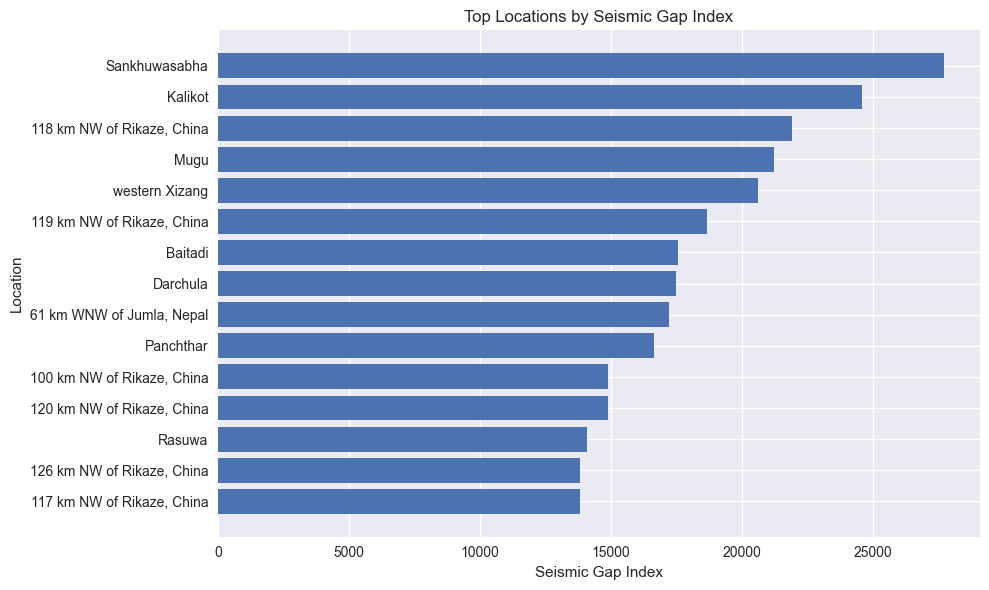

In [9]:
top_risk = (
    risk_table
    .sort_values("seismic_gap_index", ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
plt.barh(
    top_risk["place"],
    top_risk["seismic_gap_index"]
)

plt.title("Top Locations by Seismic Gap Index")
plt.xlabel("Seismic Gap Index")
plt.ylabel("Location")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../outputs/figures/seismic_gap_top_locations.png", dpi=150)
plt.show()


In [10]:
recent_window = df[df["timestamp"] >= (latest_date - pd.Timedelta(days=365))]
long_term_window = df[df["timestamp"] >= (latest_date - pd.Timedelta(days=365*5))]

recent_counts = recent_window.groupby("place").size()
long_term_counts = long_term_window.groupby("place").size()

activity_ratio = (
    (recent_counts / long_term_counts)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

risk_table["recent_activity_ratio"] = (
    risk_table["place"].map(activity_ratio).fillna(0)
)

risk_table[["place", "recent_activity_ratio"]].sort_values(
    "recent_activity_ratio", ascending=False
).head(10)


,place,recent_activity_ratio
127,"60 km WNW of Jumla, Nepal",1.0
197,Southern Tibetan Plateau,1.0
161,"Dinggye, China",1.0
24,"126 km W of Rikaze, China",1.0
54,2025 Southern Tibetan Plateau Earthquake,1.0
142,"83 km NE of Lobuche, Nepal",1.0
11,"11 km SSW of Kodāri̇̄, Nepal",1.0
30,"137 km N of Lobuche, Nepal",1.0
148,"96 km NNE of Lobuche, Nepal",1.0
201,"Tingri, China",1.0


In [11]:
risk_table["risk_signal"] = np.where(
    (risk_table["seismic_gap_index"] > risk_table["seismic_gap_index"].quantile(0.75)) &
    (risk_table["recent_activity_ratio"] > 1),
    "Elevated",
    "Normal"
)

risk_table["risk_signal"].value_counts()


risk_signal
Normal    204
Name: count, dtype: int64

In [12]:
risk_table.to_csv(
    "../data/processed/seismic_risk_signals.csv",
    index=False
)


Risk Signal & Seismic Gap Summary

This analysis identifies potential seismic risk signals by combining long-term inactivity (seismic gaps), historical activity levels, and recent acceleration patterns. Locations with prolonged silence following historically frequent seismic activity, combined with recent tremor increases, are flagged as elevated-risk candidates for monitoring. This approach emphasizes explainability and supports early-warning analytics without attempting deterministic earthquake prediction.